In [2]:
'''
# TRY HOTSPOTS

Take a time-flattened sample of papers and identify clusters

Within the spatial extent of ID'd clusters, track the dynamics of publications and citations over time


'''

"\n# TRY HOTSPOTS\n\nTake a time-flattened sample of papers and identify clusters\n\nWithin the spatial extent of ID'd clusters, track the dynamics of publications and citations over time\n\n\n"

In [3]:
import pymysql
import pickle
import json

import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'

import time
import hdbscan

In [4]:
db_name = 'test_pubmed'  # db name collisons? https://stackoverflow.com/questions/14011968/user-cant-access-a-database
config_path = '/home/brendan/Projects/AttentionWildfires/attention_wildfires/mysql_config.json'

with open(config_path, 'r') as f:
    config_data = json.load(f)
    
client_config = {'database': db_name,
                'user': config_data['user'],
                 'password': config_data['lock']}

db = pymysql.connect(**client_config)

########################
## load pre-fit dimensionality reduction models

print('pop open pickle jar: umap model...')
umap_path = "/home/brendan/FastData/pubmed2019/pubmed_data_processing/dimensionality_reduction_models/umap2D/umap_model0.pkl"
with open(umap_path, 'rb') as file:
    umap_model = pickle.load(file)
    
#########################
## control params

sample_id = 0
path2dir = '/home/brendan/FastData/pubmed2019/pubmed_data_processing/sample_pmids/'  # knowledge-garden
path2sample = path2dir + 'sample{}.json'.format(sample_id)
print(path2sample)

pop open pickle jar: umap model...
/home/brendan/FastData/pubmed2019/pubmed_data_processing/sample_pmids/sample0.json


In [5]:
# get sample pmids

In [13]:
with open(path2sample,'r') as f:
    data = json.load(f)

#print(data.keys())
#print(data['sample_fraction'])
#print(data['do_resample'])
#print(data['sample_rows'][0])  # pmid, year, journal
N_pubs = len(data['sample_rows'])
print("N pubs: {}".format(N_pubs))

# todo could filter by year here...

K_sample = 5000
sample = {}
sample['pmids'] = np.random.choice([row[0] for row in data['sample_rows']], K_sample)
del data

print("N sampled: {}".format(len(sample['pmids'])))

N pubs: 98470
N sampled: 5000


In [14]:
# helper function for selecting the embedding vectors

def get_embedding_vectors(sample_pmids):
    str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])

    sql = '''SELECT E.pmid, E.embedding
            FROM scibert_mean_embedding as E
            WHERE E.pmid IN ({})'''.format(str_fmt)

    start_time = time.time()
    cursor = db.cursor()
    cursor.execute(sql)
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL join executed in {} s".format(elapsed))
    
    start_time = time.time()
    pub_embeddings = []
    pub_pmids = []
    for i,row in enumerate(cursor):
        print_block_len = 100000
        if (i+1) % print_block_len == 0:
            print('fetched {} rows...'.format(print_block_len))
        pub_pmids.append(row[0])
        pub_embeddings.append(np.frombuffer(row[1],dtype='float16').tolist())
    cursor.close()
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL results fetched and cast in {} s".format(elapsed))
    
    return pub_pmids, pub_embeddings

In [15]:

pmids, embeddings = get_embedding_vectors(sample['pmids'])
print("N samples with embedding: {}".format(len(embeddings)))
sample['pmids'] = pmids  # remove pmids with no corresponding embedding (e.g. no abstract)
sample['raw_coordinates'] = embeddings
print('compressing...')
sample['umap2D'] = umap_model.transform(embeddings)

SQL join executed in 0.6835882663726807 s
SQL results fetched and cast in 0.08145928382873535 s
N samples with embedding: 2976
compressing...


Text(0.5, 1.0, 'published: time-flattened')

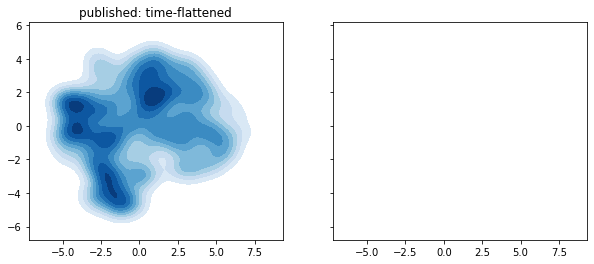

In [16]:
# sanity check - umap plot of the sample

(f, ax) = plt.subplots(1,
                       2,
                       sharex='all', sharey='all',
                       figsize=(10,4))

sns.kdeplot(sample['umap2D'][:,0], # these are pca'd
            sample['umap2D'][:,1],
            ax=ax[0],
            shade=True,
    shade_lowest=False,
            cmap='Blues')
ax[0].set_title('published: time-flattened')


In [17]:
# identify hotspots using hdbscan


num clusters: 7


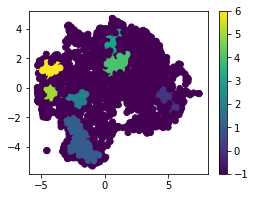

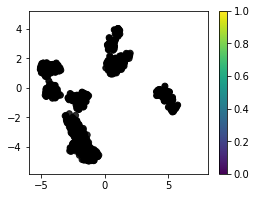

In [18]:

    clusterer = hdbscan.HDBSCAN(min_cluster_size=50,  # 50
                            min_samples=50,   # 100
                            cluster_selection_method='leaf')  # euclidean distance
    clusterer.fit(sample['umap2D'])  # samples x features

    # number of clusters
    print('num clusters: {}'.format(clusterer.labels_.max()+1))
    
    # plot clusters
    plt.figure(figsize=(4,3))
    plt.scatter(sample['umap2D'][:,0],
               sample['umap2D'][:,1],
               c=clusterer.labels_)
    plt.colorbar()
    plt.show()

    # plot clusters using probabilities_ estimate  (todo combine plots)
    rgba = np.zeros( (np.shape(sample['umap2D'])[0], 4) )
    rgba[:,3] = clusterer.probabilities_
    plt.figure(figsize=(4,3))
    plt.scatter(sample['umap2D'][:,0],
               sample['umap2D'][:,1],
               c=rgba)
    plt.colorbar()
    plt.show()
